## 初期設定

In [40]:
from datetime import datetime
from time import sleep
import requests
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from mpl_finance import candlestick2_ohlc, volume_overlay
%matplotlib inline

In [2]:
# UNIX時間から文字列に変換
def t2s(the_time):
    return datetime.fromtimestamp(int(the_time)).strftime('%Y/%m/%d %H:%M')

## 5分足の取得

In [3]:
import mysql.connector

cnt = mysql.connector.connect(
    host='localhost',
    port='3306',
    db='bitmex',
    user='bitmex',
    password='bitmex',
    charset='utf8'
)

cur = cnt.cursor()

In [4]:
sql = "select t, o, h, l, c, v from xbtusd_5m order by t asc"
cur.execute(sql)
data = cur.fetchall()

## Pandas に変換

In [5]:
df = pd.DataFrame(data)
df.columns = ["Time", "Open", "High", "Low", "Close", "Volume"]

In [6]:
print(df.index)
df[0:10]

RangeIndex(start=0, stop=213560, step=1)


,Time,Open,High,Low,Close,Volume
0,1483228800,968.3,968.8,966.7,967.0,119555
1,1483229100,967.0,967.0,966.9,966.9,26962
2,1483229400,966.9,966.9,964.9,964.9,124137
3,1483229700,964.9,965.0,964.8,964.8,3001
4,1483230000,964.8,964.8,964.8,964.8,0
5,1483230300,964.8,965.1,964.5,964.9,48000
6,1483230600,964.9,965.0,964.9,965.0,2501
7,1483230900,965.0,967.8,965.6,967.8,130501
8,1483231200,967.8,967.8,967.1,967.1,50
9,1483231500,967.1,967.4,967.4,967.4,100


## 分析

In [7]:
time_frame = 180 # 考慮するのは2時間
bar_type   = 5   # 5分足
frame_size = int(time_frame / bar_type)  # データ数

In [8]:
bars_prev_base_price = 1    # 判断基準となる価格を算出する足の数
bars_ahead_prediction = 12  # 価格を予測するバーが現在からどの程度離れているか
deviation_criteria = 5  # 価格の変動優位性を考慮する基準 (%)
bars_risk_rewards_calc = 12 # リスクリワードを計算する時に用いる過去バーの数

### 一定時間内の値動きと将来価格の関係性について集計

In [26]:
run_times = 10000
results = []
for i in range(run_times):
    idx = random.randint(0,len(df)-frame_size-bars_ahead_prediction)
    idx2 = idx + frame_size
    idx3 = idx2 + bars_ahead_prediction
    ds = df[idx:idx2]
    ds2 = df[idx:idx3]
    
    base_price = np.mean( df[idx2-bars_prev_base_price:idx2]["Close"].values )  # 変化前価格
    future_price = df[idx3-1:idx3]["Open"].values[0]  # 将来価格 
    diff = future_price - base_price
    deviation = diff / base_price * 100.0  # 変化率 (%)
    
    # リスクリワードの計算
    rds = df[idx2-bars_risk_rewards_calc:idx2]
    highs = rds['High'].values
    lows = rds['Low'].values
    highest = max(highs)
    lowest = min(lows)
    if deviation > 0:
        risk = base_price - lowest
        reward = future_price - base_price
    else:
        risk = highest - base_price
        reward = base_price - future_price

    rs_ratio = reward / risk if risk > 0.0 else 0.0

    results.append( (deviation, abs(deviation), diff, rs_ratio, base_price, future_price, idx, idx2, idx3) )

In [27]:
ret = pd.DataFrame(results)
ret.columns = ["Dev", "DevA", "Diff", "RRR", "Base", "Future", "idx", "idx2", "idx3"]

ここで各カラムの意味は次の通り
 - Dev: 将来価格が現在に比べてどの程度変化したか (%)
 - DevA: Dev の絶対値
 - Diff: 将来価格の現在価格からの変化 (USD)
 - RRR: Risk Reward Ratio
 - Baes: 現在価格
 - Future: 将来価格
 - idx: 過去データの開始インデックス
 - idx2: 将来価格データの開始インデックス
 - idx3: 将来価格算出のためのインデックス (idx3-1のデータを使用）

In [28]:
ret[0:10]

,Dev,DevA,Diff,RRR,Base,Future,idx,idx2,idx3
0,-0.573274,0.573274,-12.6,0.464945,2197.9,2185.3,43208,43244,43256
1,0.533938,0.533938,15.3,0.336264,2865.5,2880.8,46304,46340,46352
2,-0.221545,0.221545,-16.0,0.615385,7222.0,7206.0,175302,175338,175350
3,-0.128447,0.128447,-8.5,0.531250,6617.5,6609.0,181859,181895,181907
4,-0.192134,0.192134,-8.5,0.333333,4424.0,4415.5,198618,198654,198666
5,-0.719172,0.719172,-112.5,0.569620,15643.0,15530.5,102198,102234,102246
6,-0.032071,0.032071,-2.1,0.411765,6547.9,6545.8,87641,87677,87689
7,-1.316720,1.316720,-121.0,2.000000,9189.5,9068.5,125549,125585,125597
8,0.998807,0.998807,134.0,0.822086,13416.0,13550.0,105118,105154,105166
9,0.065854,0.065854,4.0,0.285714,6074.0,6078.0,170127,170163,170175


### 将来価格の変化量と発生回数

In [29]:
devs = ret["DevA"]
hist_fig = plt.hist(devs, bins=100)

In [30]:
devs = ret["Dev"]
plt.ylim(0,100)
hist_fig = plt.hist(devs, bins=100)

In [31]:
freqs = []
details = []
dev_targets = list(np.arange(0.5, 5.0, 0.25))
for dev in dev_targets:
    occured = len(ret[ret["DevA"]>dev])
    rate = occured / run_times * 100
    details.append( [dev, occured, rate] )
    freqs.append(rate)

In [32]:
plt.title("生来価格の変化量と発生確率")
plt.xlabel("将来価格の変化量")
plt.ylabel("発生確率(%))")
rate_fig = plt.plot(dev_targets, freqs, marker="o")

In [33]:
plt.title("生来価格の変化量と発生確率")
plt.xlabel("将来価格の変化量")
plt.ylabel("発生確率(%))")
rate_fig2 = plt.plot(dev_targets[10:], freqs[10:], marker="o")

In [52]:
alpha = ret[ ret["DevA"]>3.5 ]
alpha2 = alpha[ alpha["RRR"] > 2]
alpha2

,Dev,DevA,Diff,RRR,Base,Future,idx,idx2,idx3
164,-4.992680,4.992680,-324.0,6.545455,6489.5,6165.5,186592,186628,186640
232,7.533414,7.533414,248.0,2.232223,3292.0,3540.0,74140,74176,74188
255,4.299088,4.299088,360.5,18.025000,8385.5,8746.0,143548,143584,143596
258,3.683344,3.683344,593.0,9.265625,16099.5,16692.5,101709,101745,101757
269,-4.128872,4.128872,-136.1,4.629252,3296.3,3160.2,74050,74086,74098
295,-3.565326,3.565326,-469.5,2.907121,13168.5,12699.0,102411,102447,102459
410,6.237793,6.237793,51.1,3.757353,819.2,870.3,1803,1839,1851
415,-4.165480,4.165480,-585.0,5.518868,14044.0,13459.0,102350,102386,102398
435,5.843211,5.843211,188.8,6.090323,3231.1,3419.9,73983,74019,74031
725,9.235197,9.235197,561.5,2.495556,6080.0,6641.5,115556,115592,115604


In [35]:
def make_plot(ds, mode="base", label=True):
    # ローソク足をプロット
    wsize = frame_size if mode=="base" else frame_size + bars_ahead_prediction
    fig = plt.figure(figsize=(wsize/6, 4))
    ax = plt.subplot(1, 1, 1)

    candlestick2_ohlc(ax, ds["Open"], ds["High"], ds["Low"], ds["Close"], width=0.9, colorup="#0000ff", colordown="#ff0000", alpha=1.0)
    #ax.set_xticklabels([(df.index[int(x)].strftime("%Y/%M/%D") if x < df.shape[0] else x) for x in ax.get_xticks()], rotation=90)
    ax.set_xlim([0, ds.shape[0]]) # 横軸の範囲はデータの個数(df.shape[0]個)までに変更しておく
    #ax.set_ylabel("Price")

    # ローソク足を上側 1/2 に収める
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom - (top - bottom) , top)


    # 出来高のチャートをプロット
    ax2 = ax.twinx()
    volume_overlay(ax2, ds["Open"], ds["Close"], ds["Volume"], width=1, colorup="#00ff00", colordown="#00ff00", alpha=1.0)
    ax2.set_xlim([0, ds.shape[0]])

    # 出来高チャートは下側 1/3 に収める
    ax2.set_ylim([0, ds["Volume"].max() * 3])
    #ax2.set_ylabel("Volume")
    
    if not label:
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.tick_params(bottom=False, left=False, right=False, top=False)
        ax2.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax2.tick_params(bottom=False, left=False, right=False, top=False)
       

In [36]:
def plot_comp(ret):
    idx = ret["idx"].values[0]
    idx2 = ret["idx2"].values[0]
    idx3 = ret["idx3"].values[0]
    ds = df[idx:idx2]
    ds2 = df[idx:idx3]
    make_plot(ds, mode="base")
    make_plot(ds2, mode="prediction")

/Users/tatsumi/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


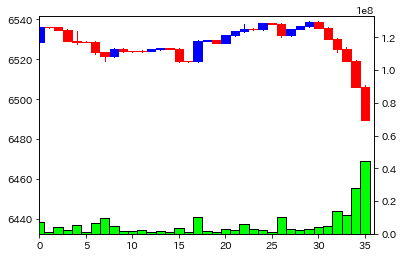

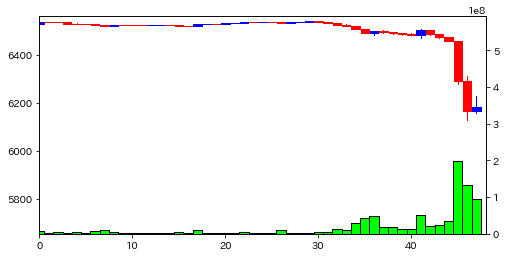

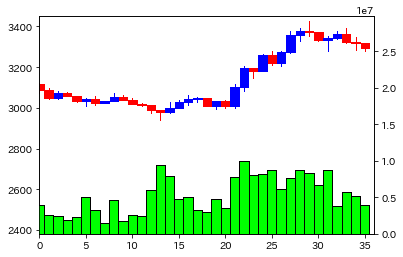

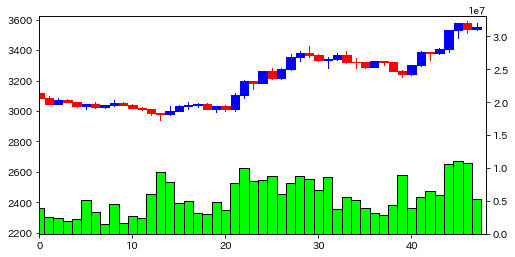

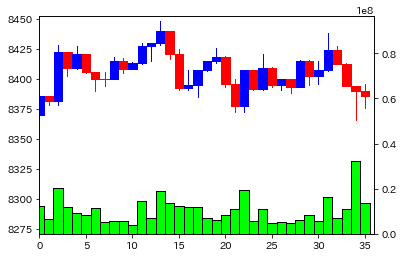

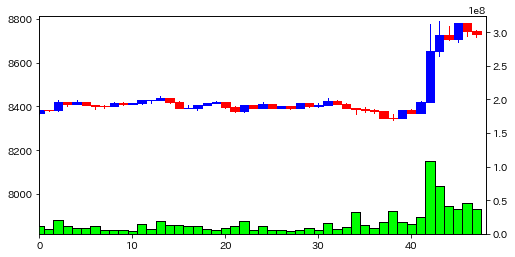

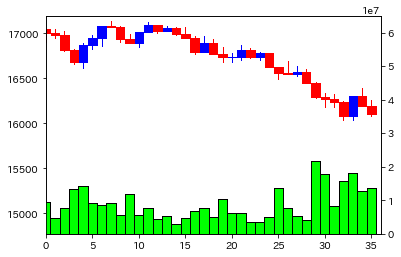

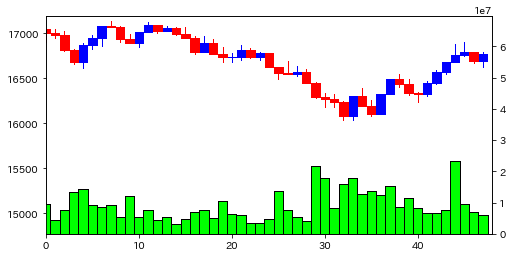

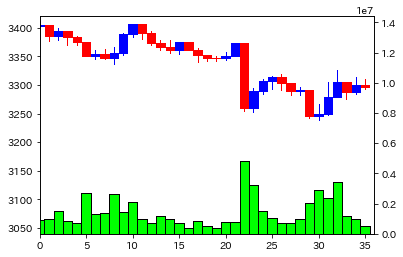

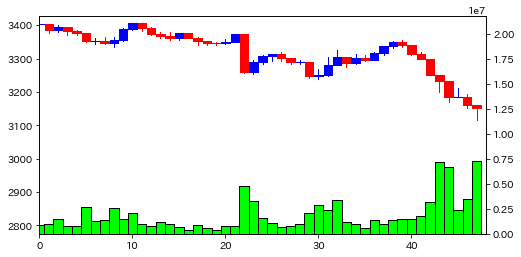

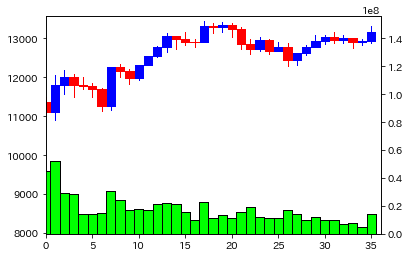

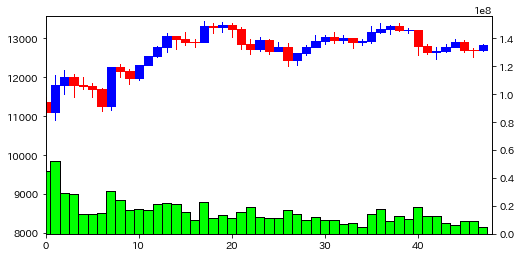

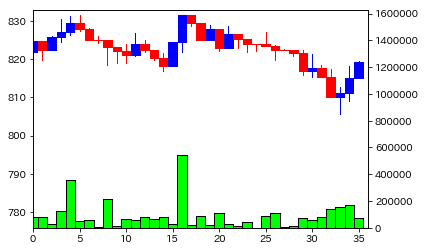

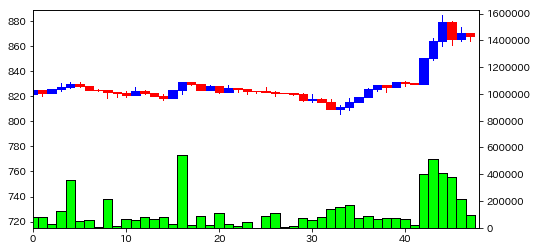

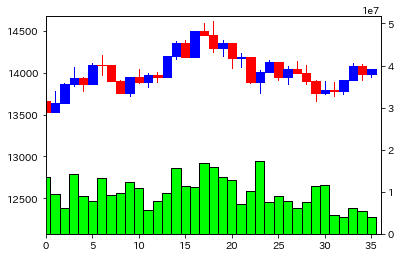

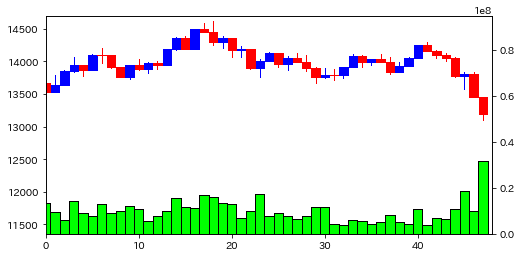

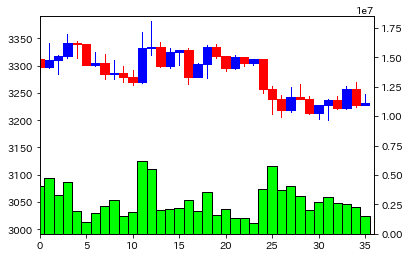

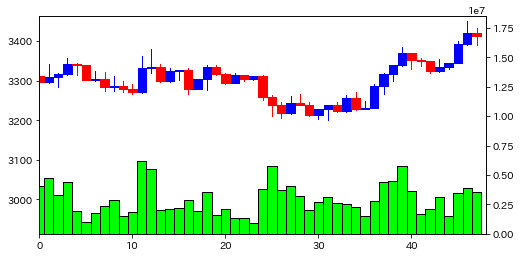

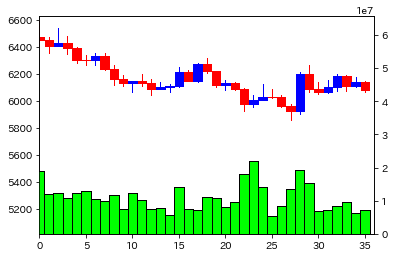

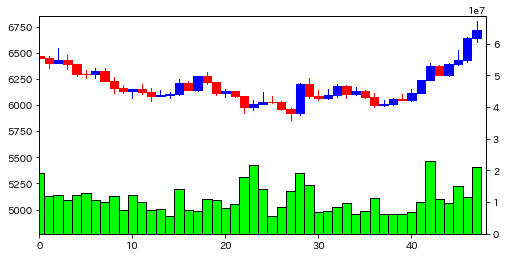

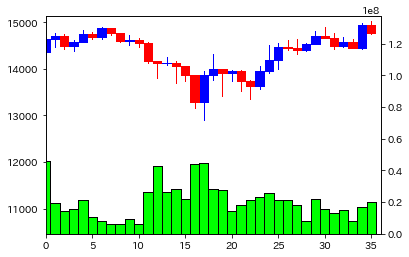

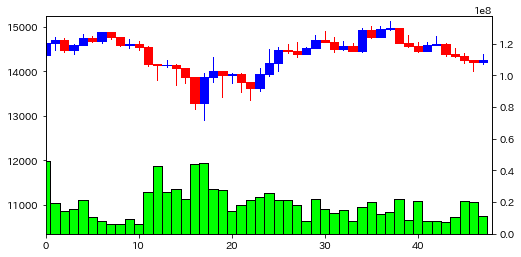

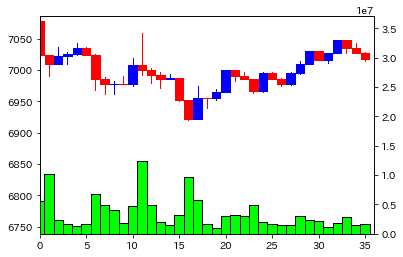

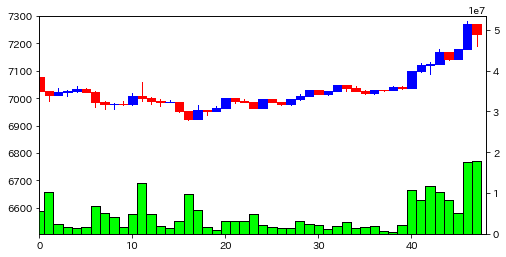

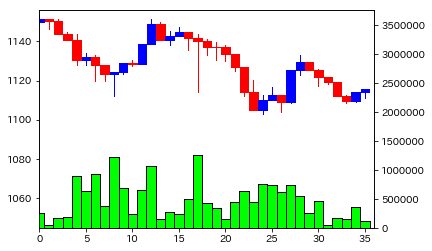

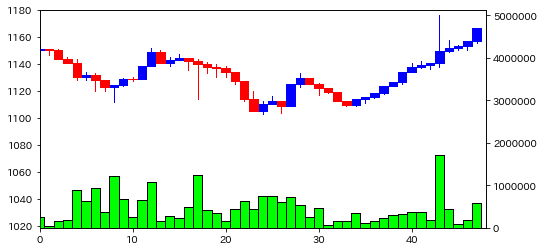

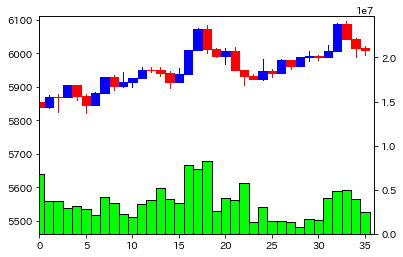

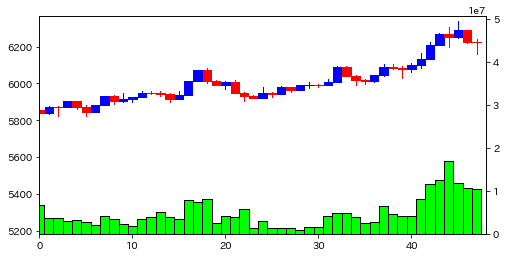

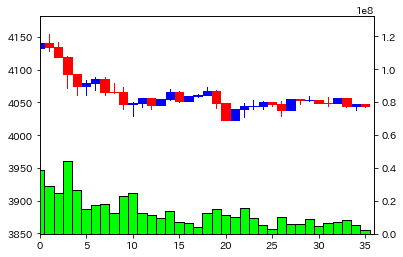

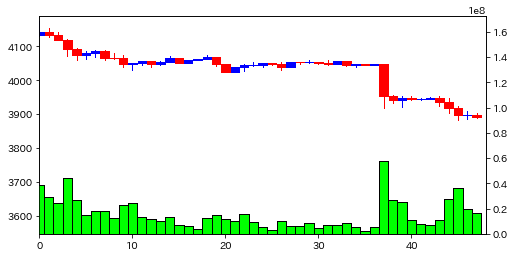

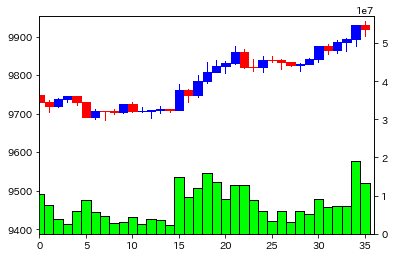

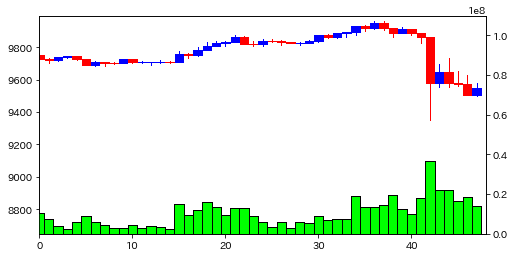

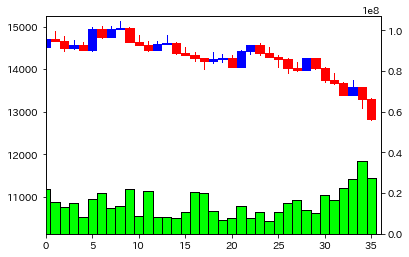

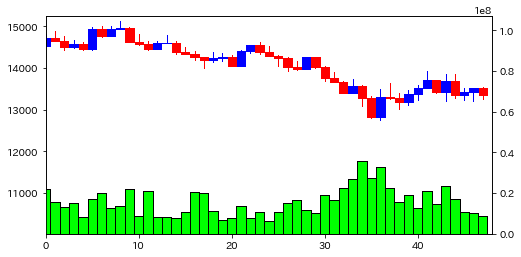

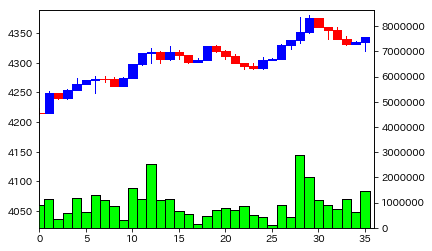

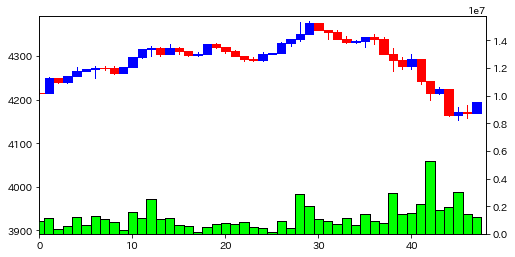

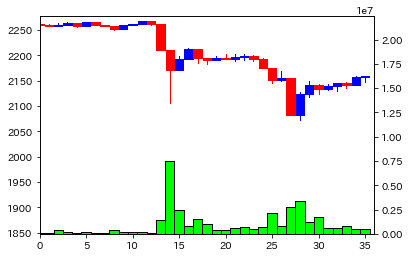

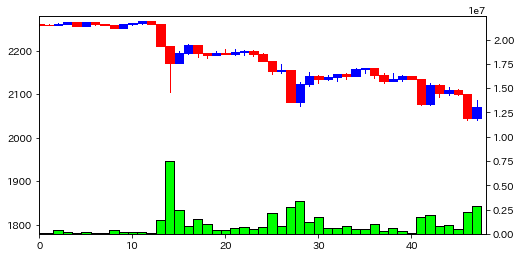

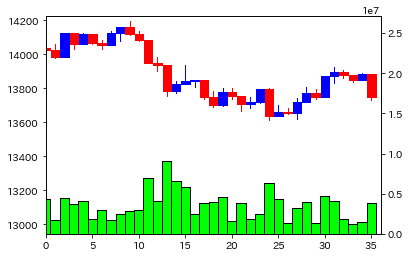

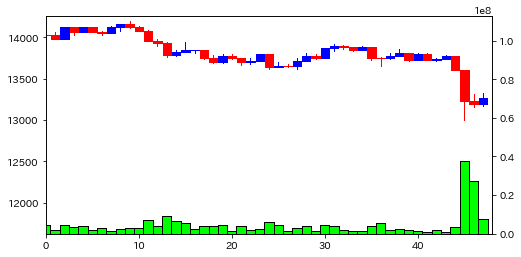

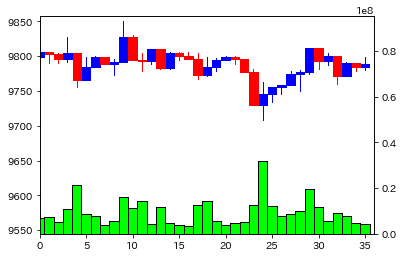

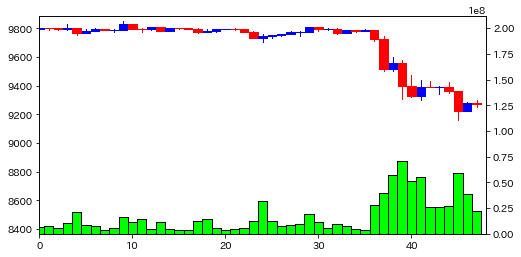

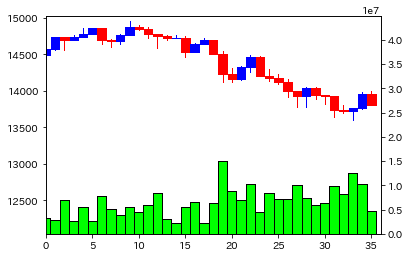

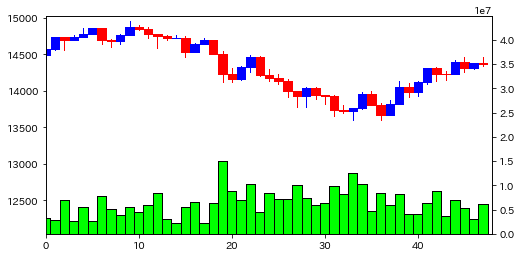

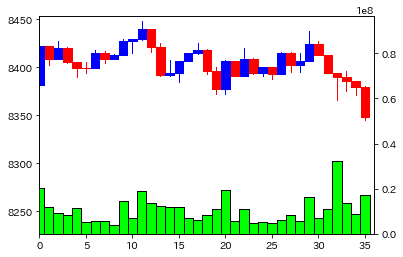

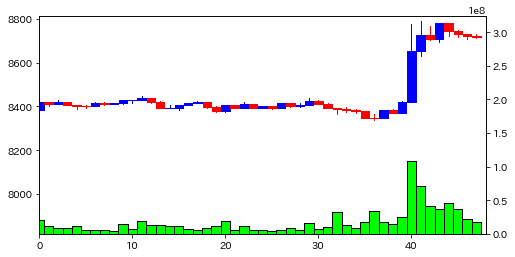

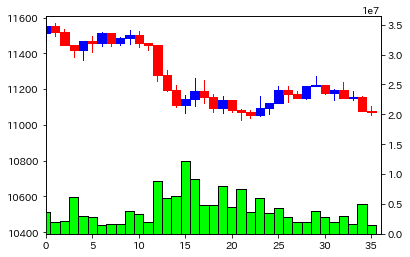

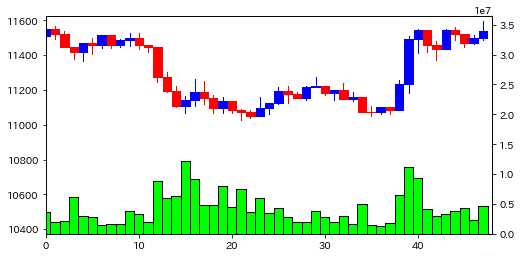

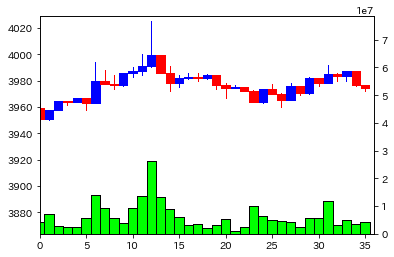

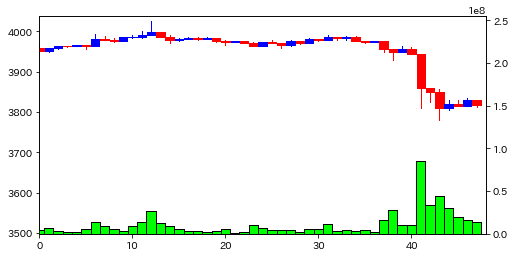

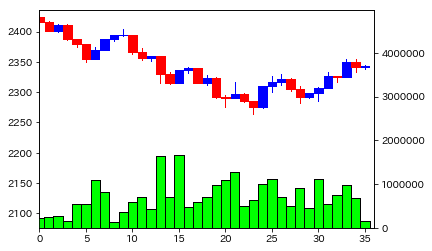

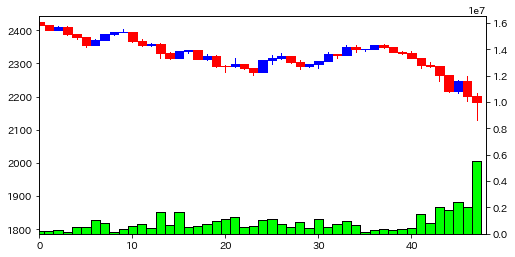

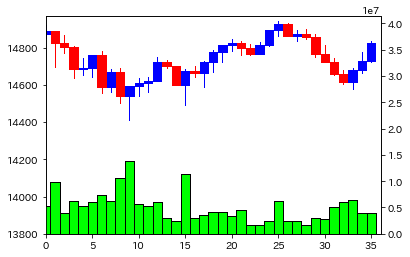

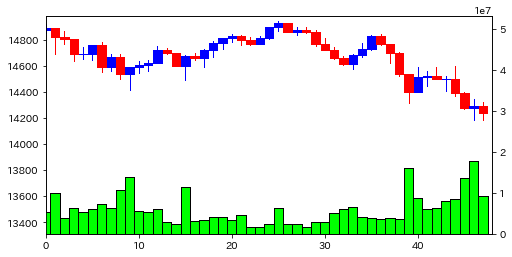

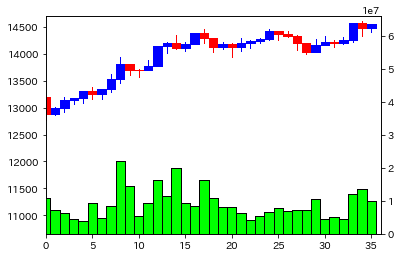

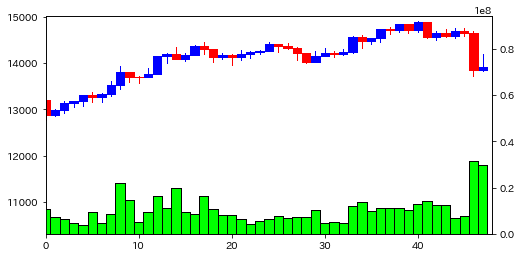

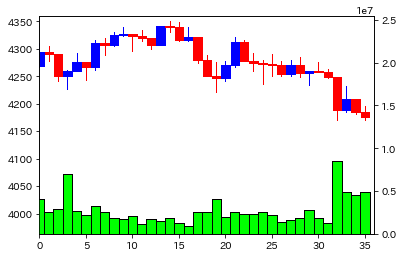

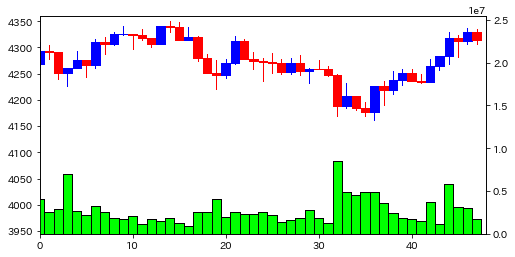

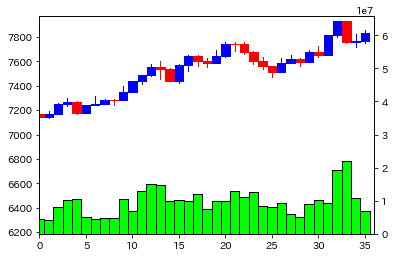

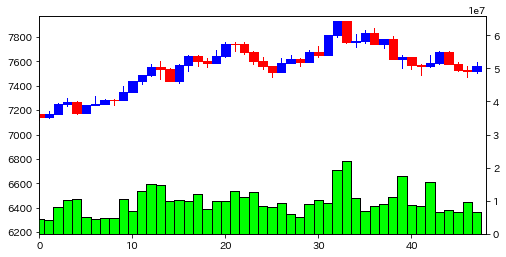

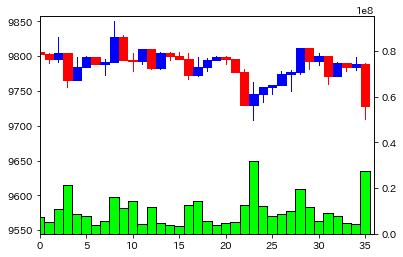

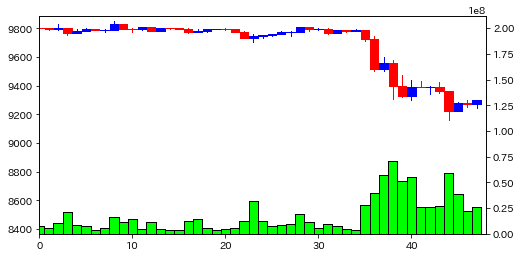

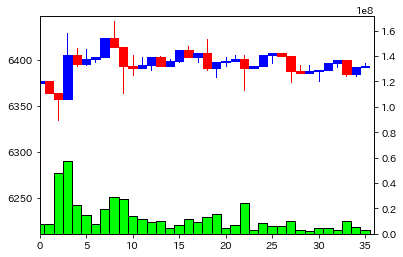

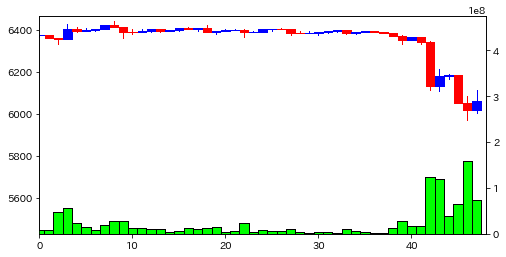

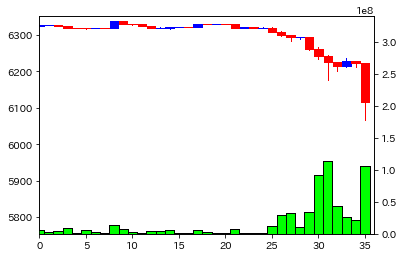

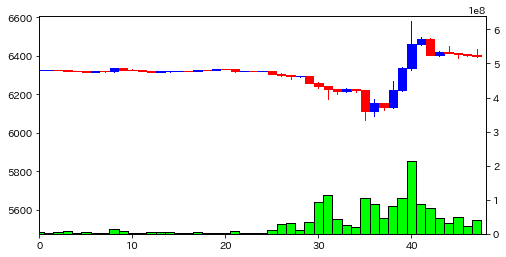

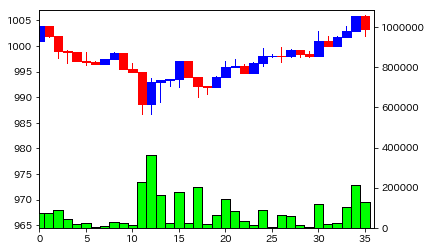

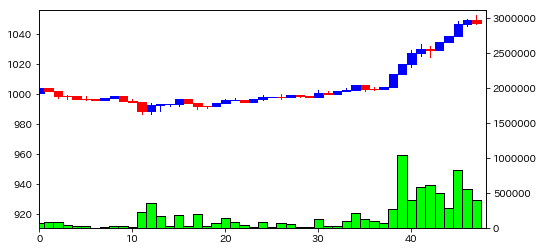

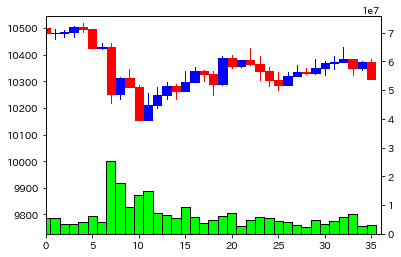

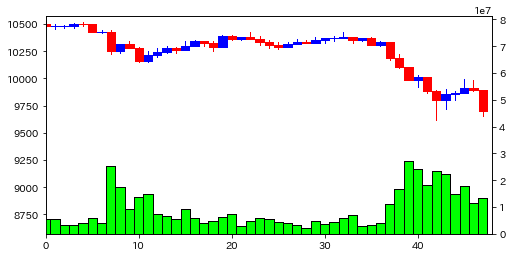

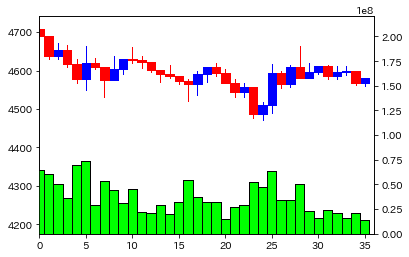

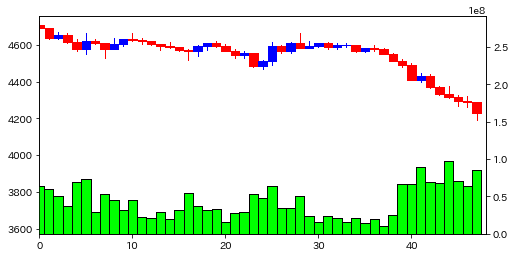

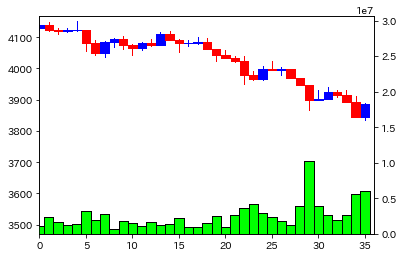

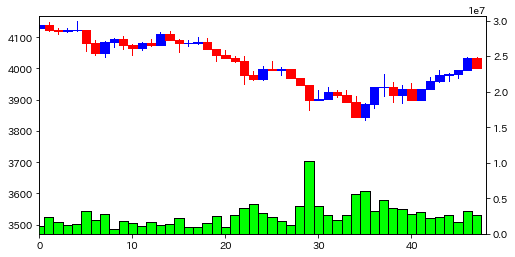

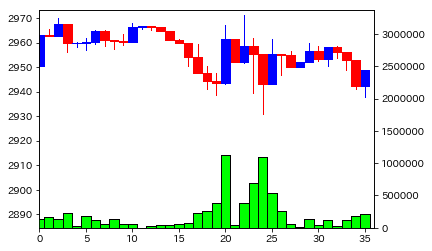

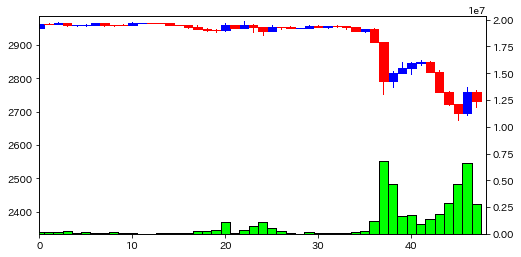

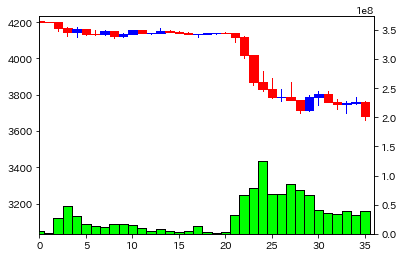

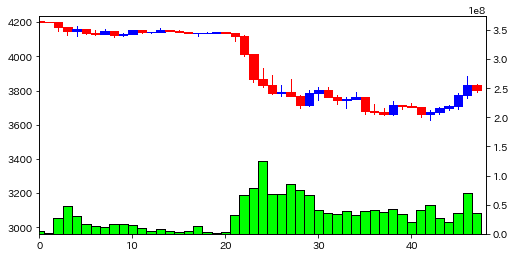

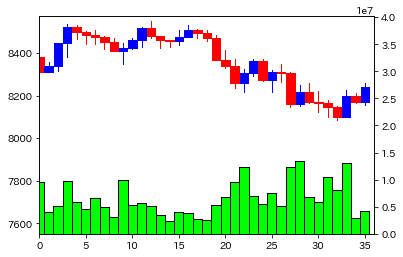

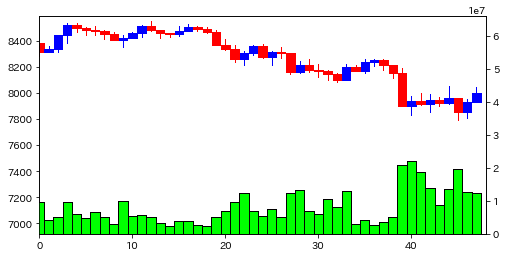

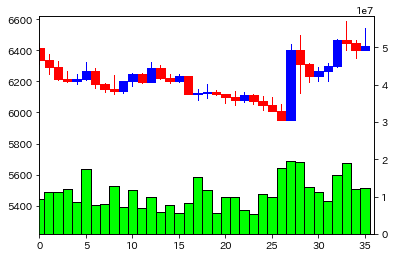

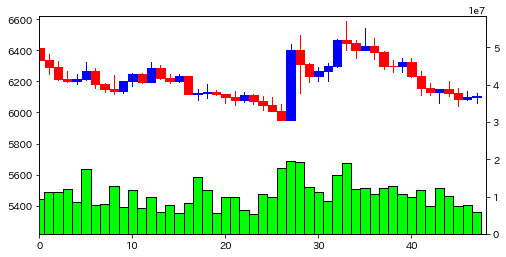

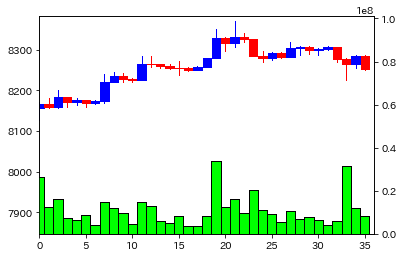

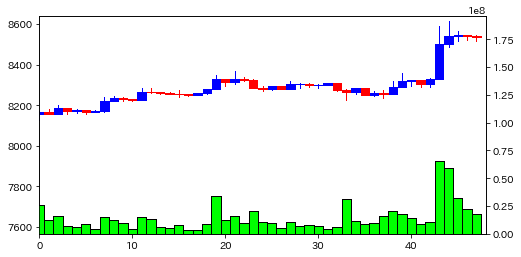

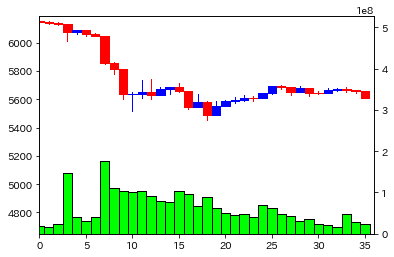

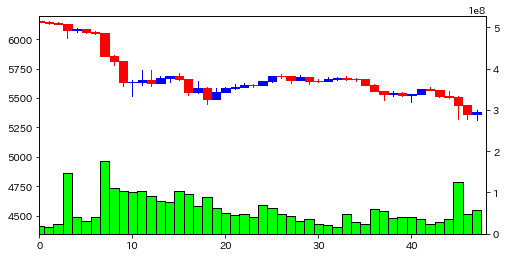

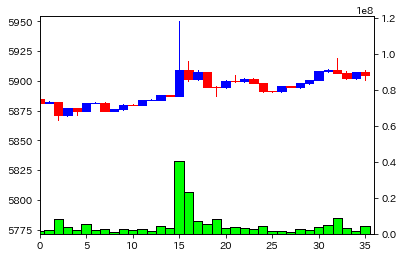

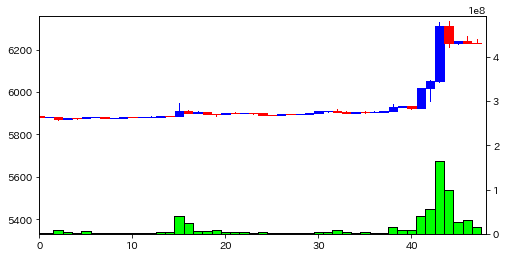

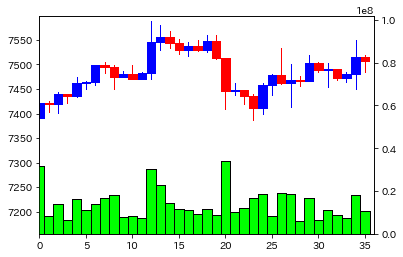

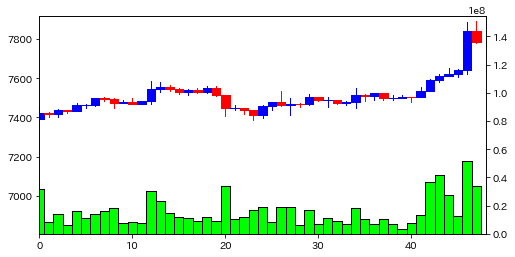

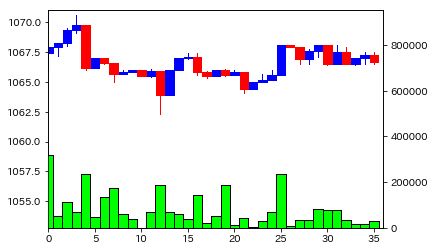

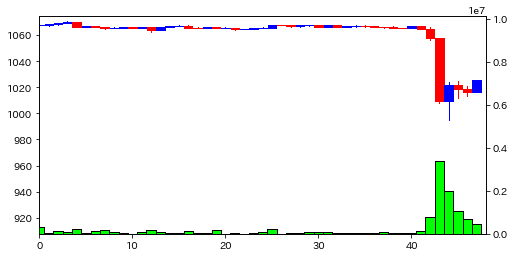

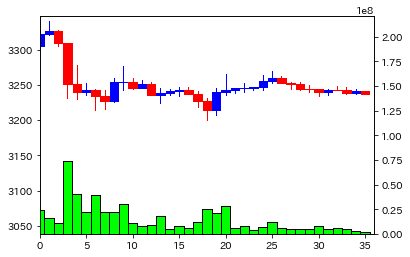

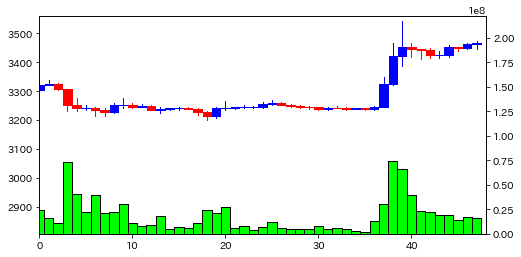

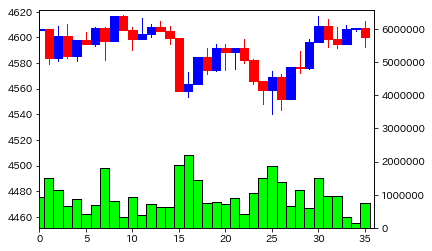

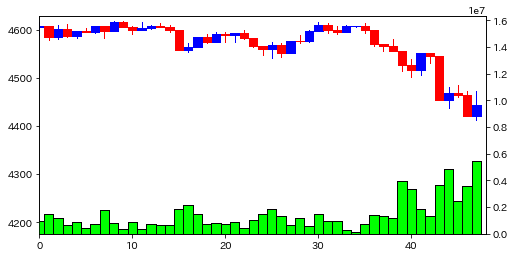

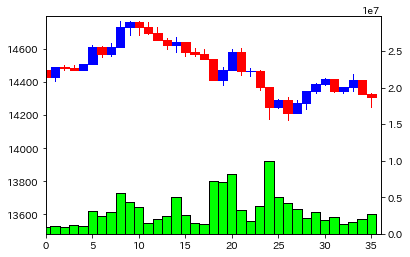

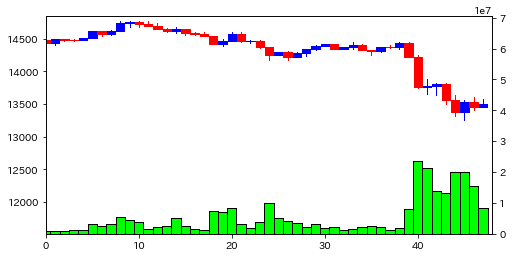

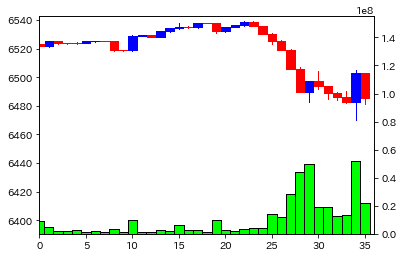

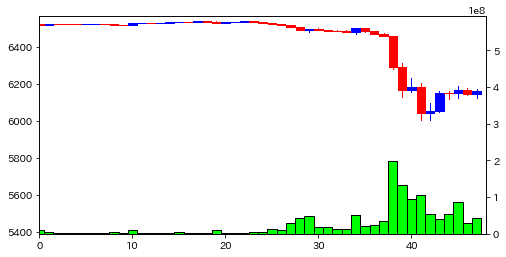

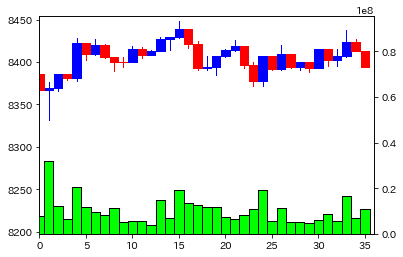

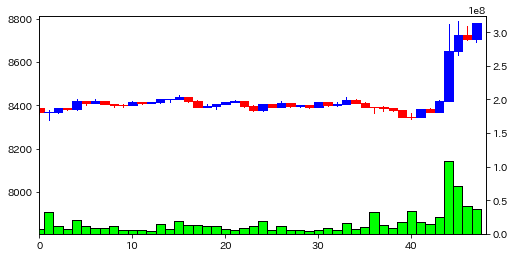

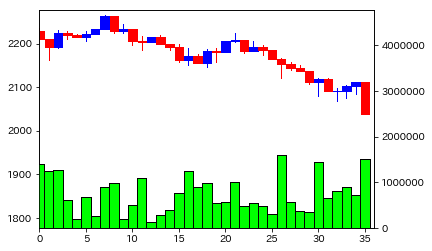

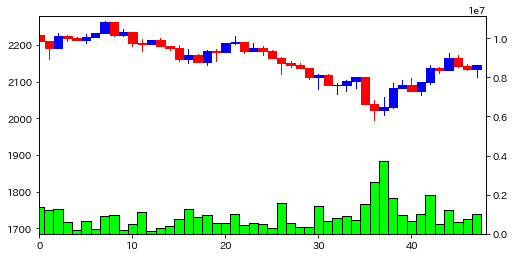

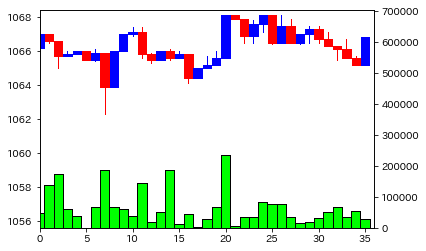

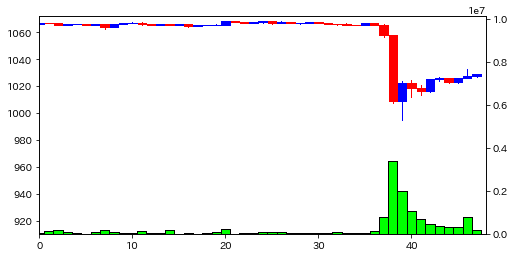

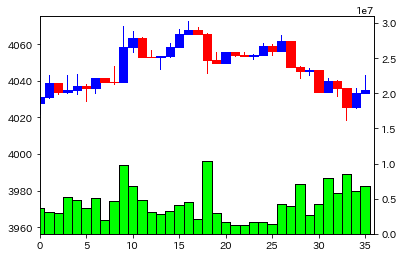

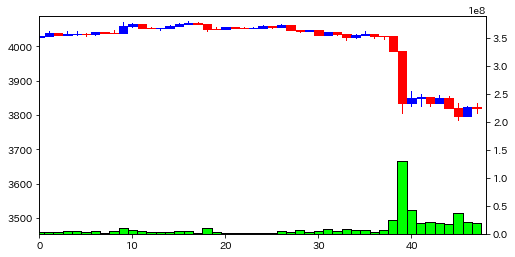

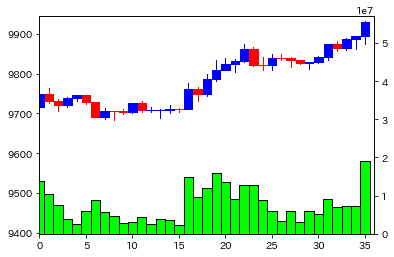

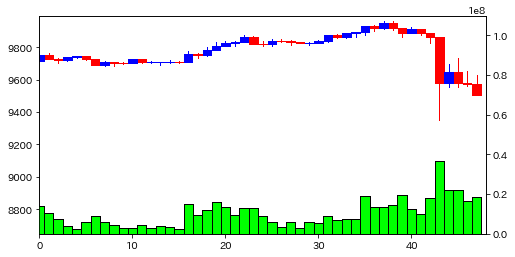

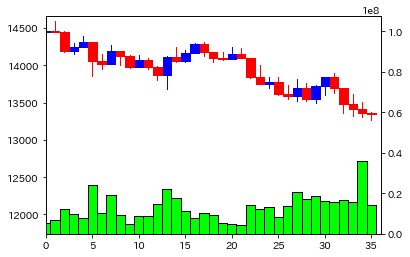

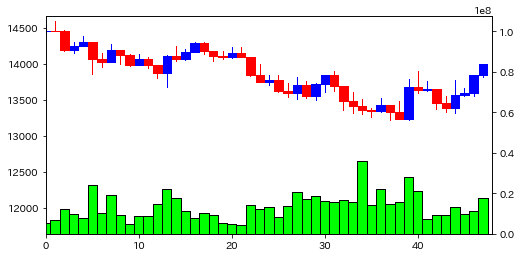

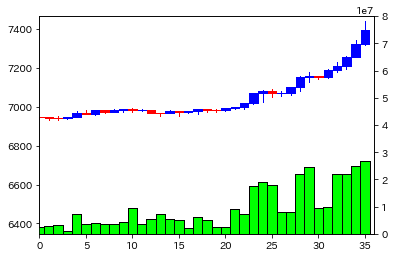

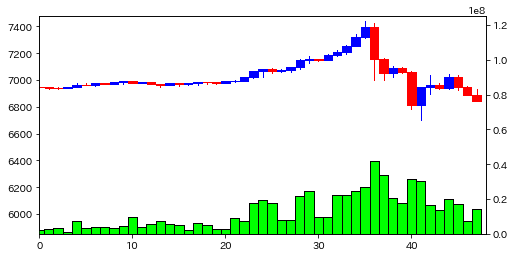

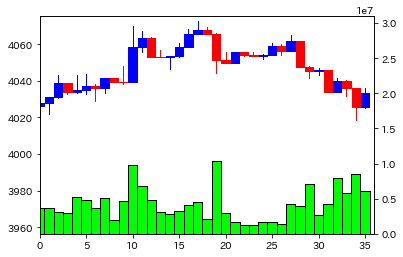

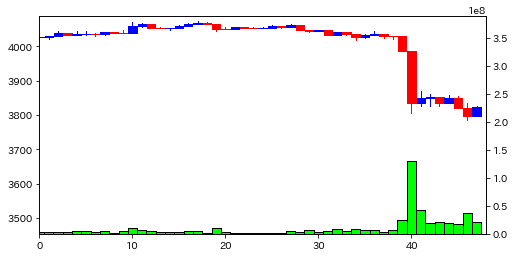

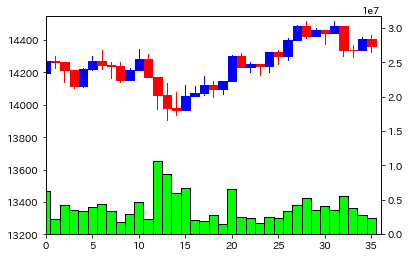

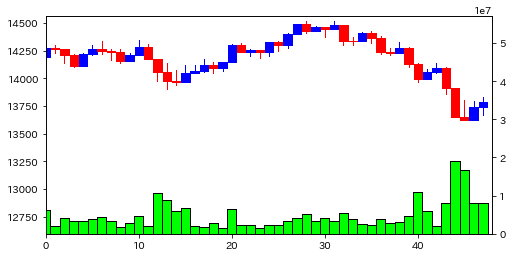

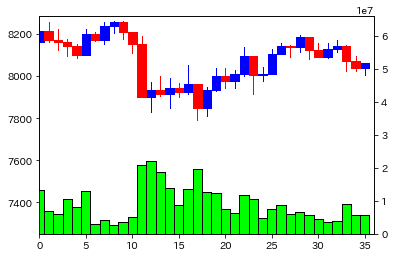

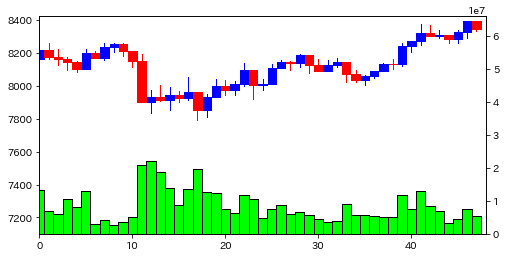

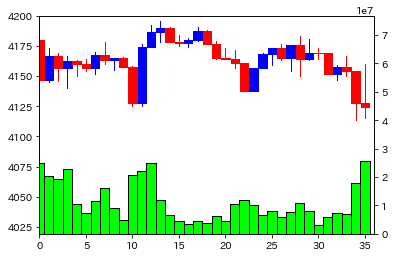

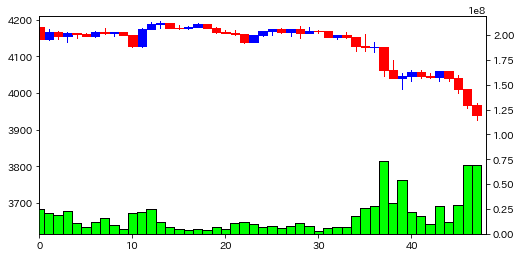

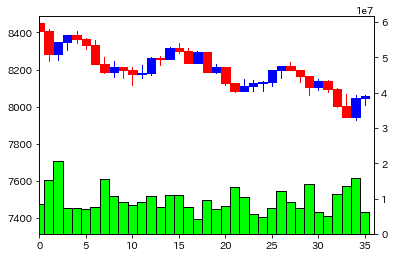

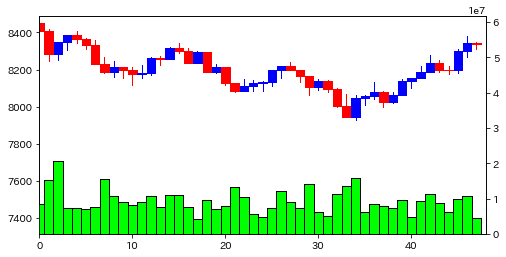

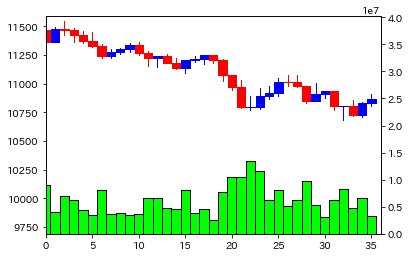

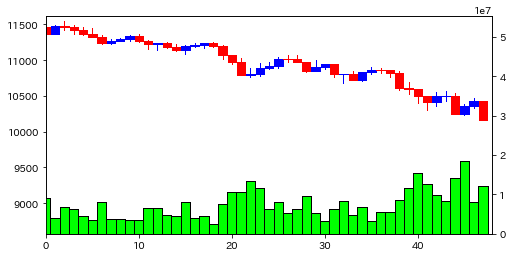

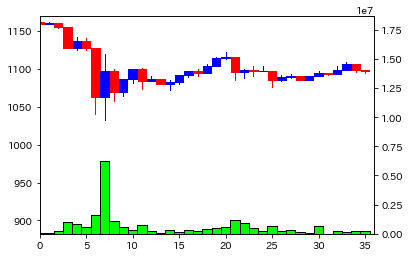

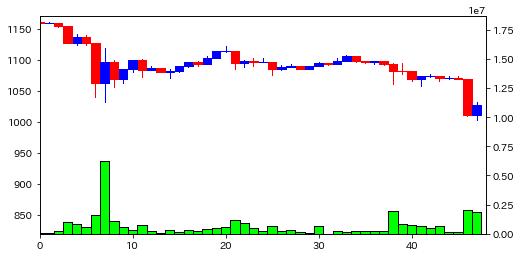

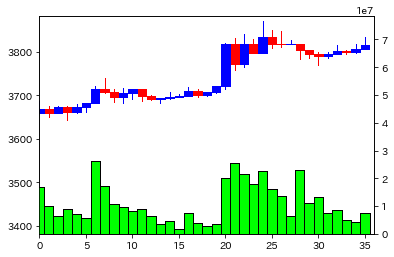

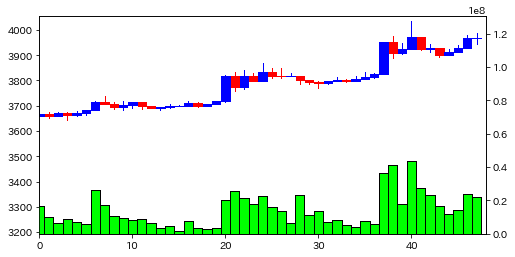

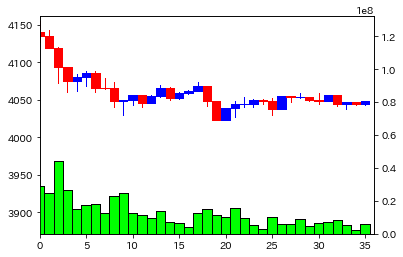

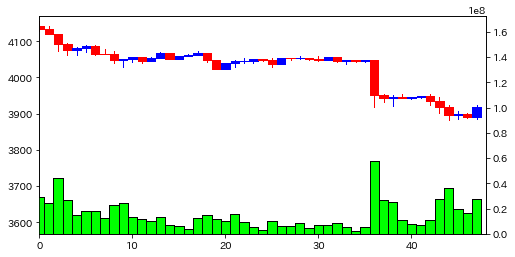

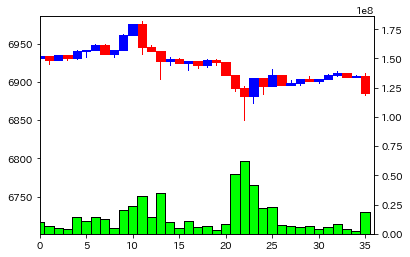

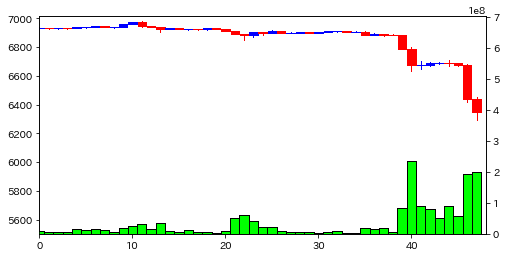

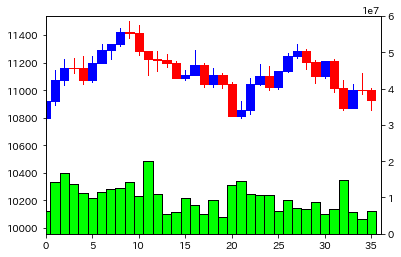

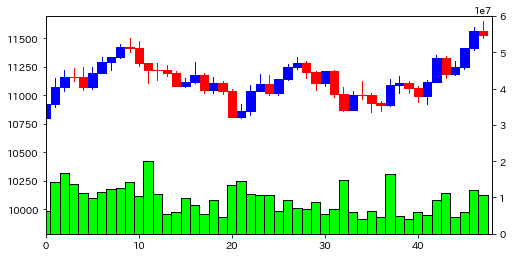

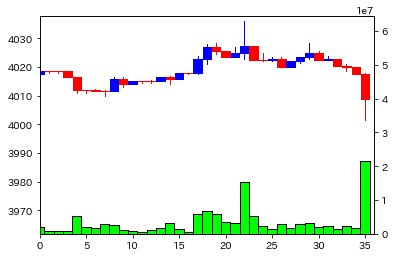

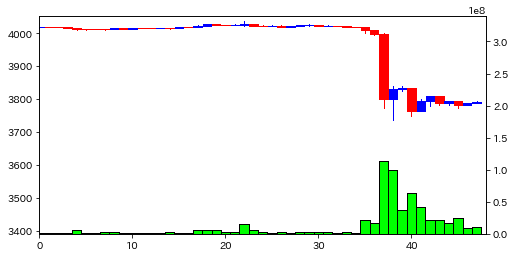

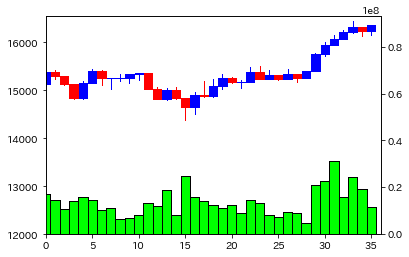

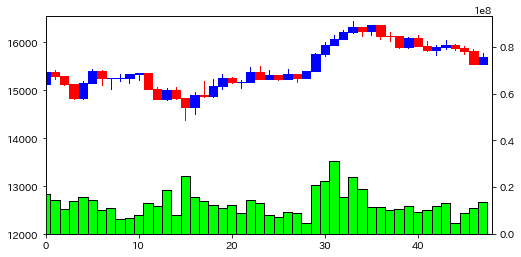

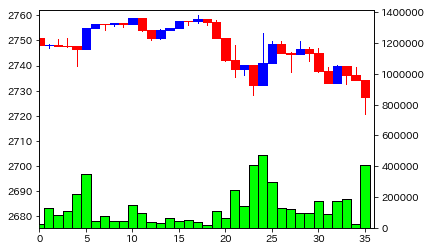

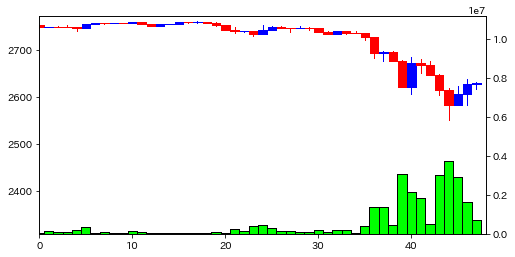

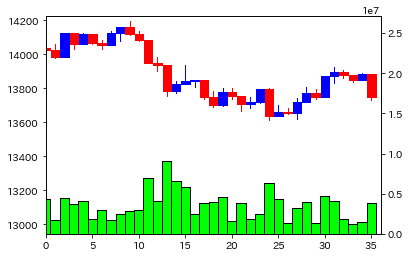

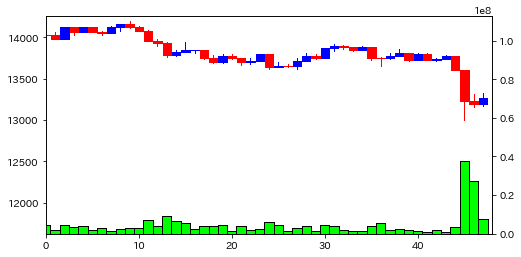

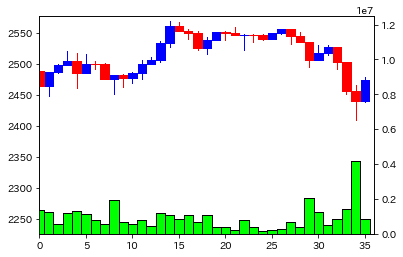

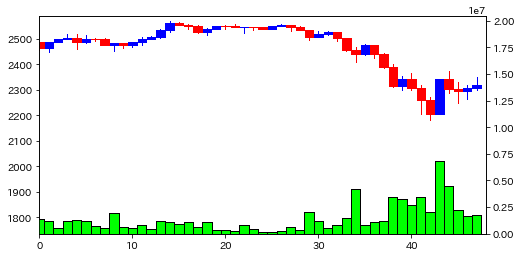

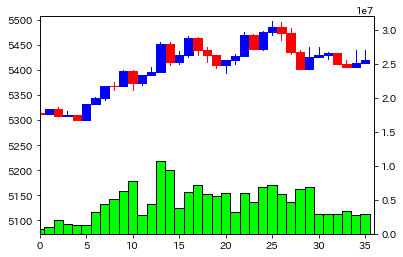

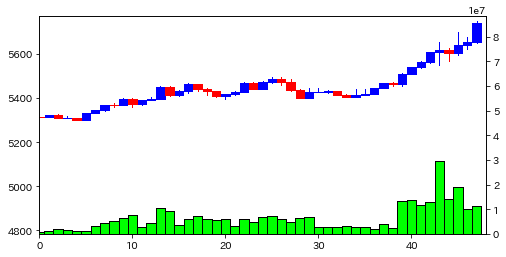

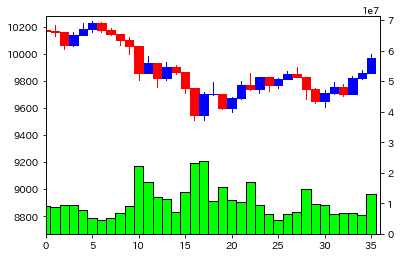

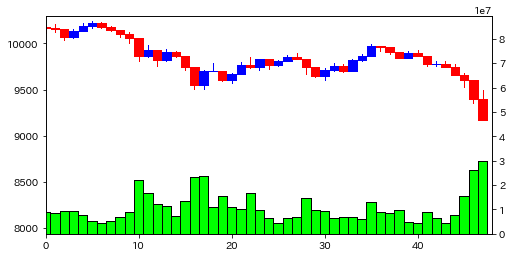

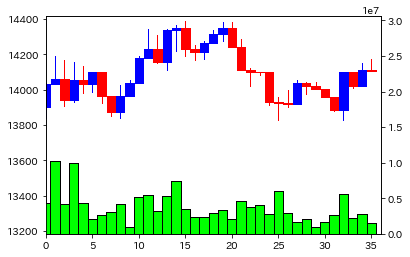

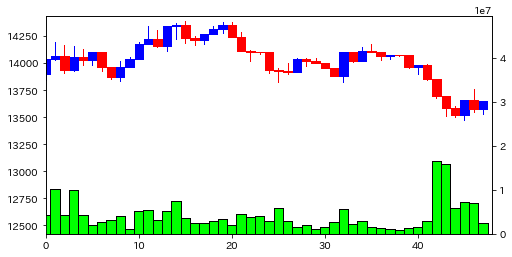

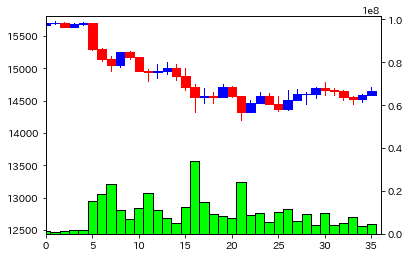

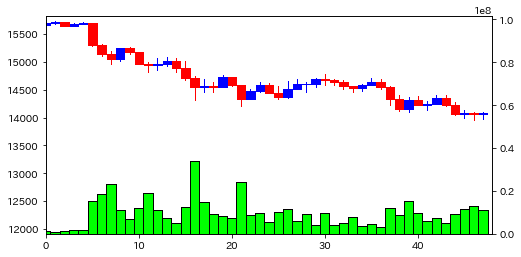

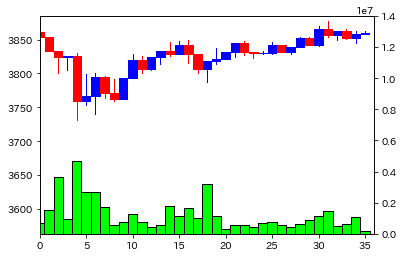

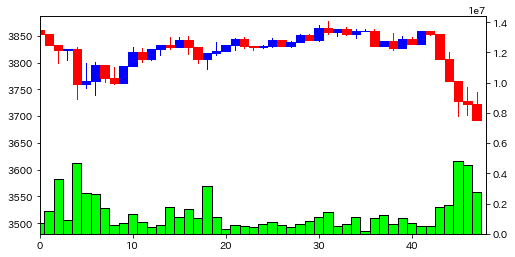

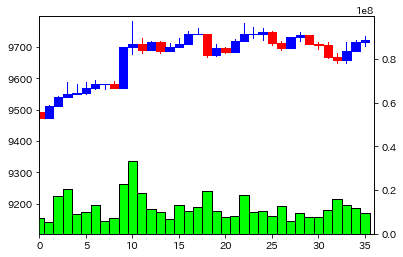

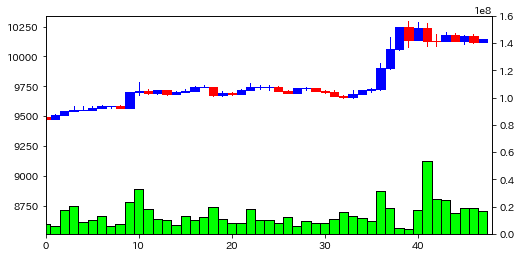

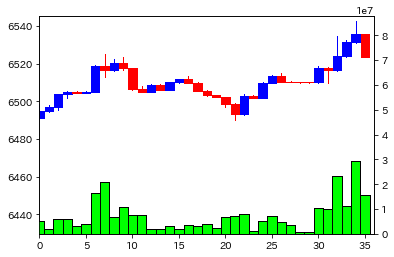

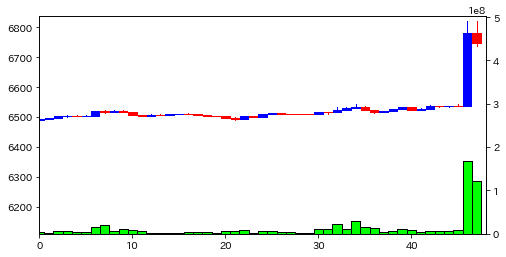

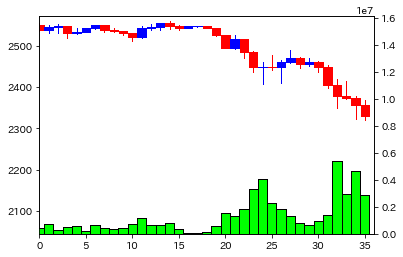

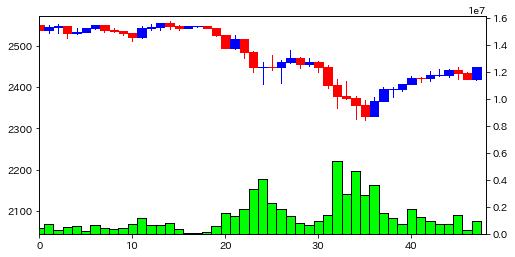

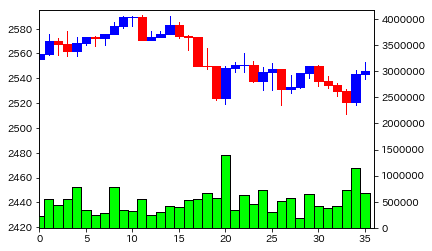

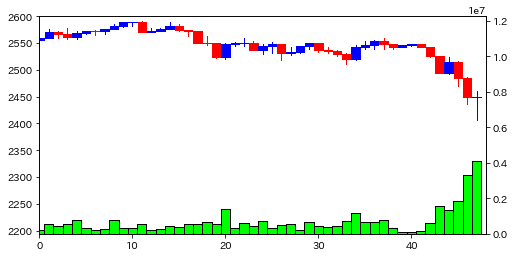

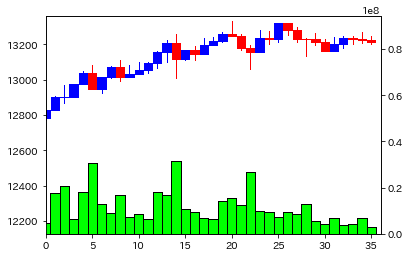

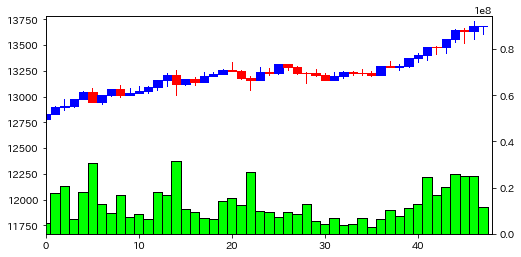

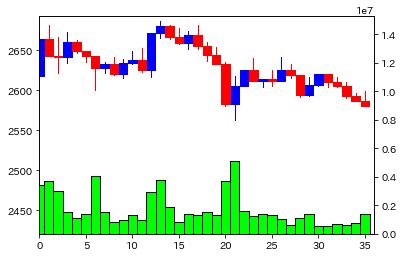

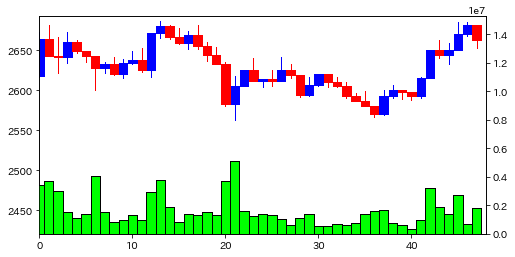

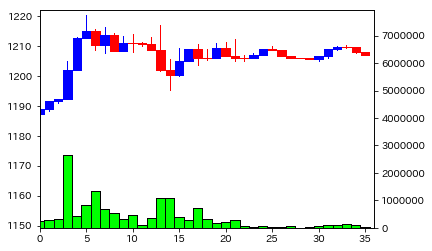

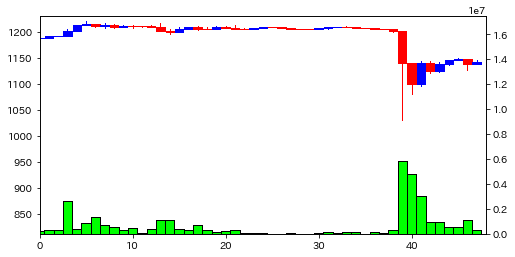

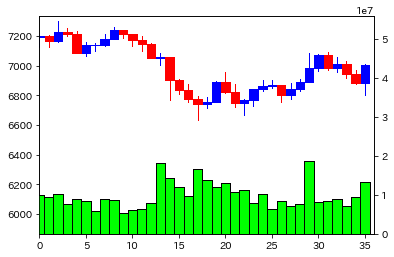

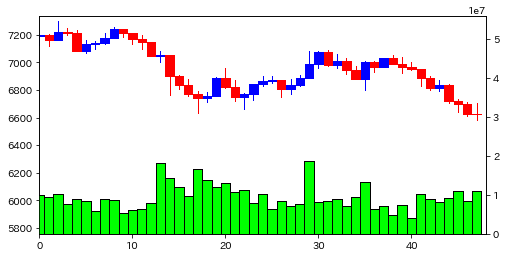

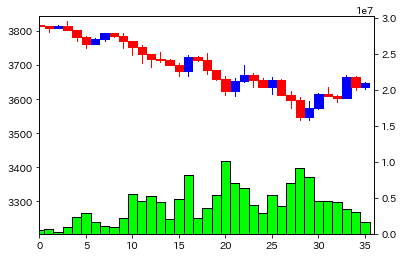

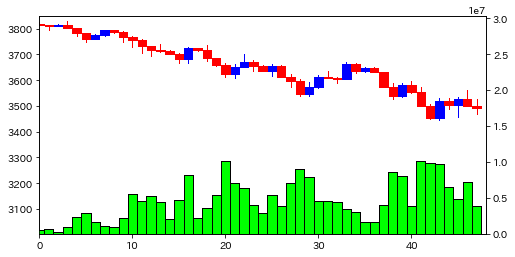

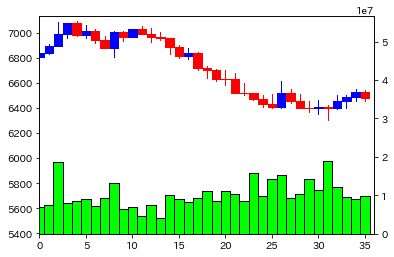

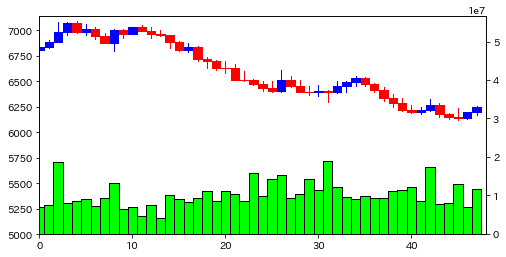

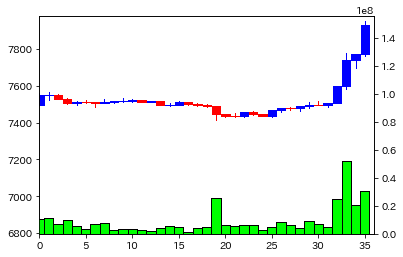

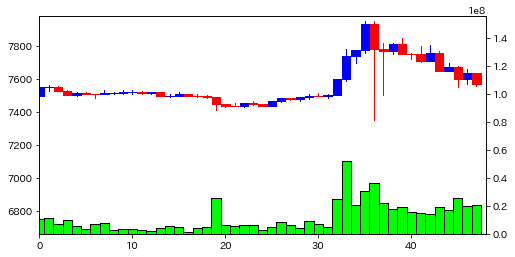

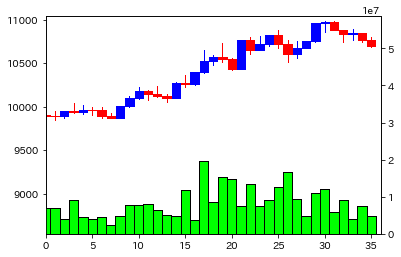

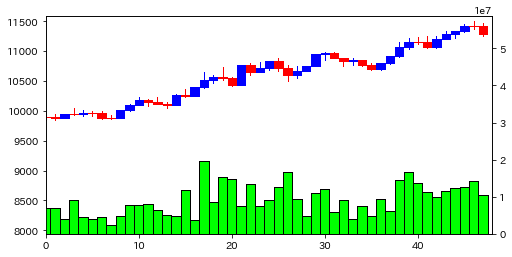

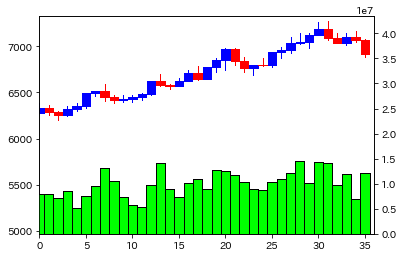

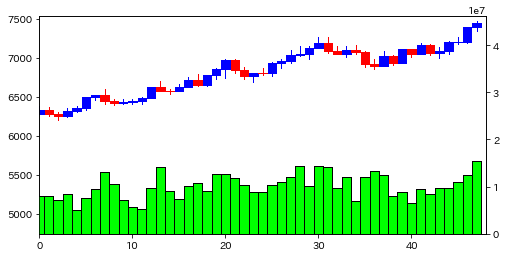

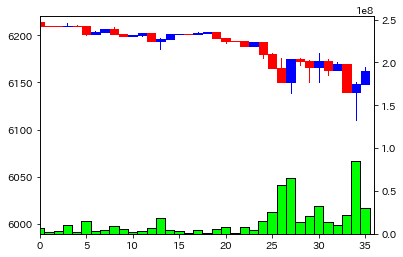

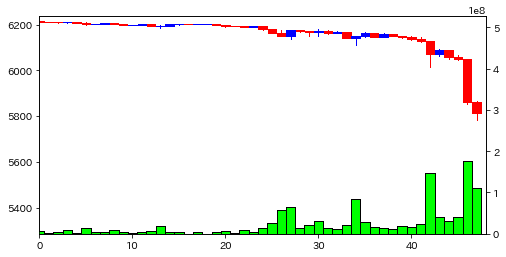

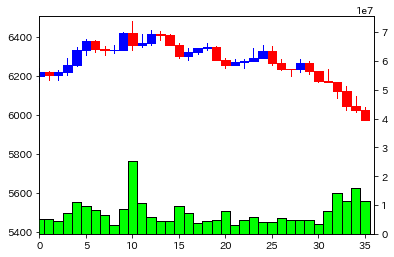

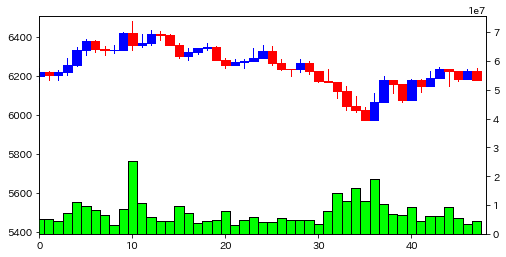

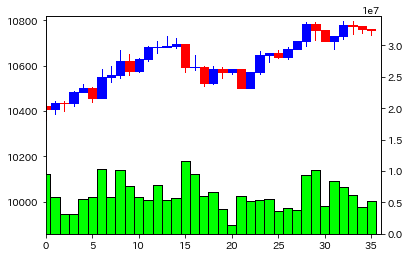

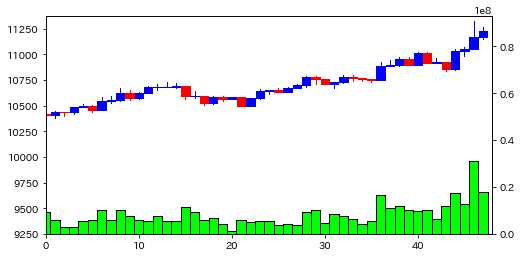

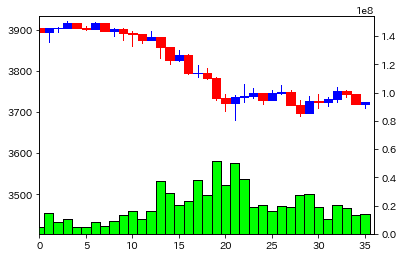

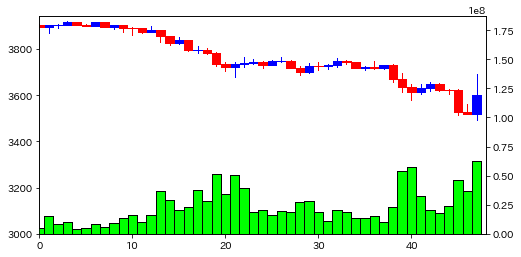

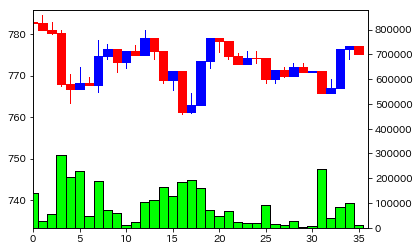

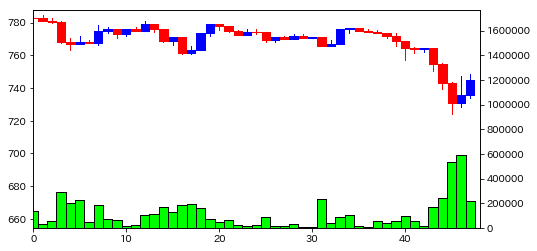

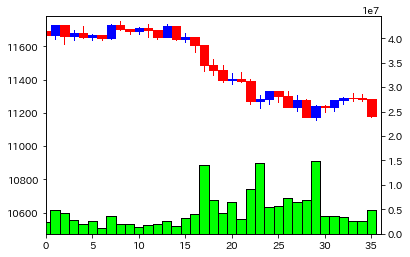

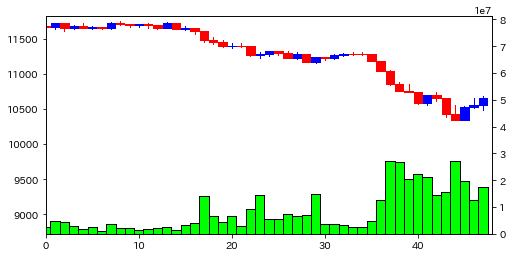

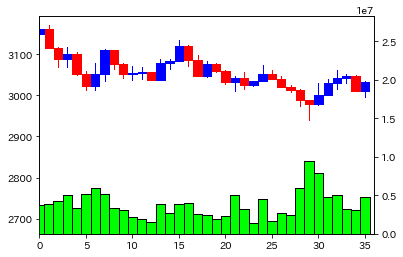

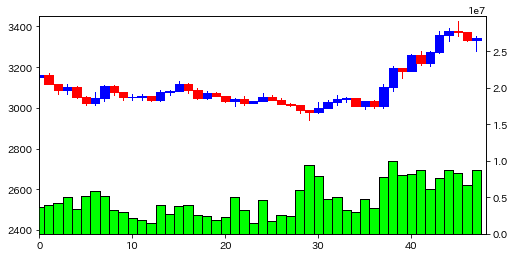

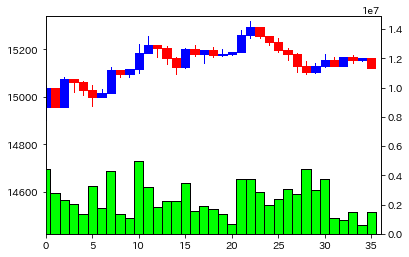

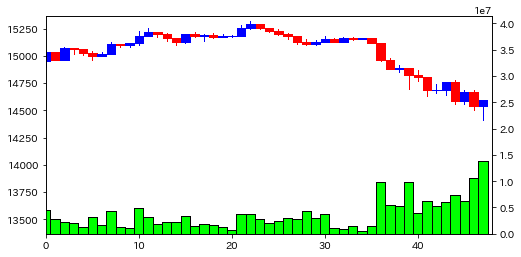

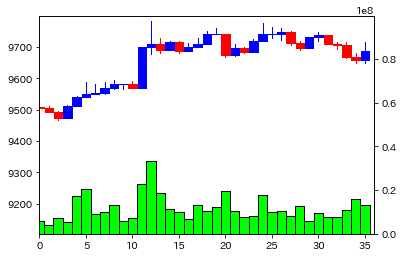

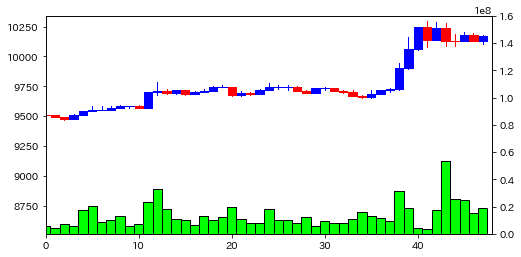

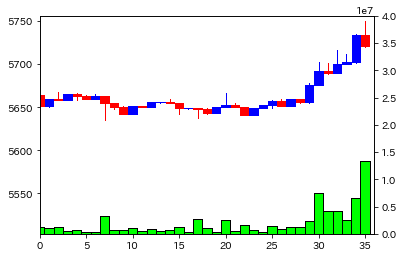

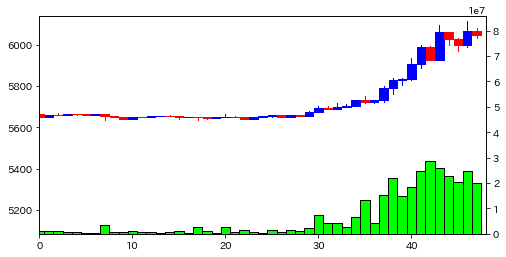

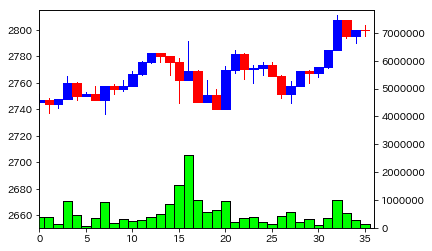

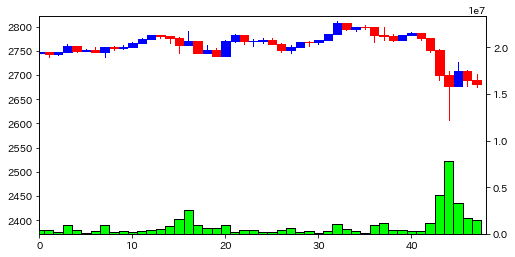

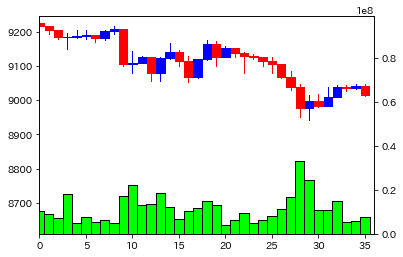

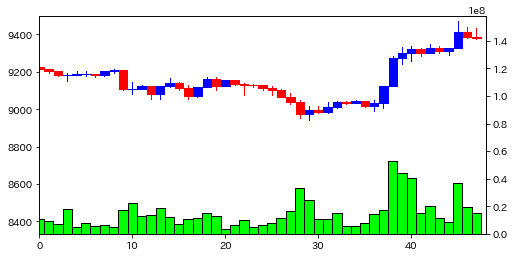

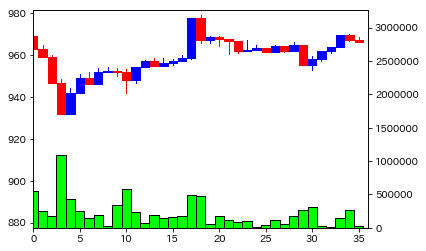

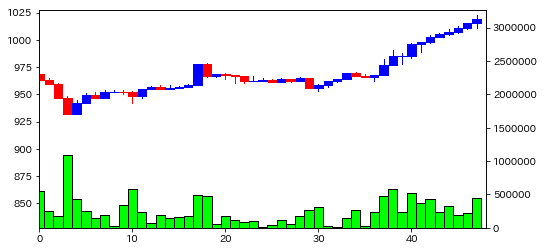

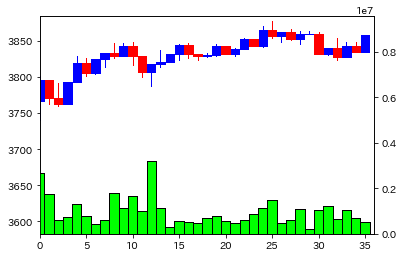

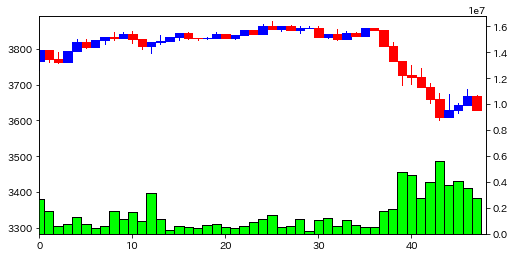

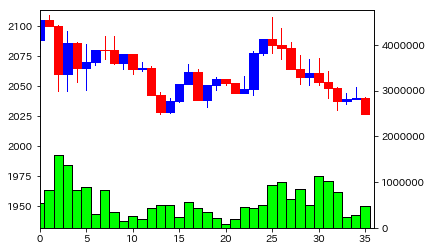

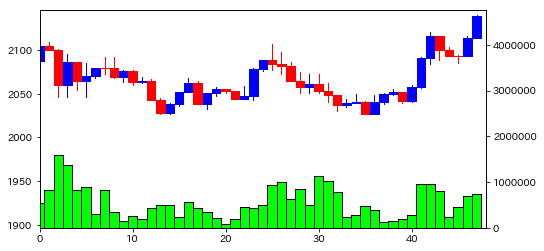

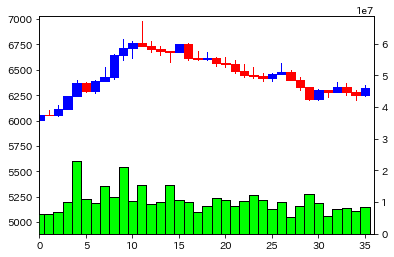

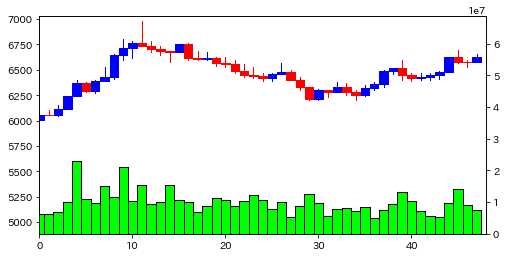

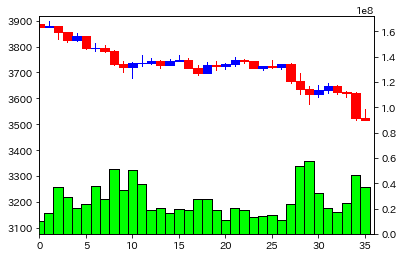

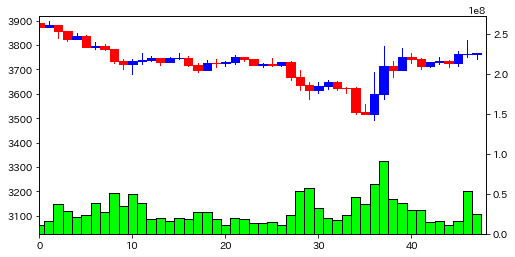

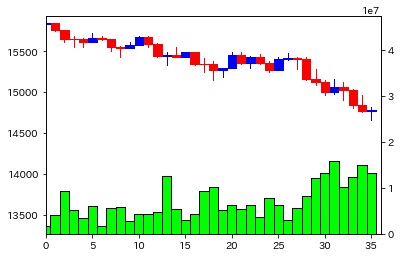

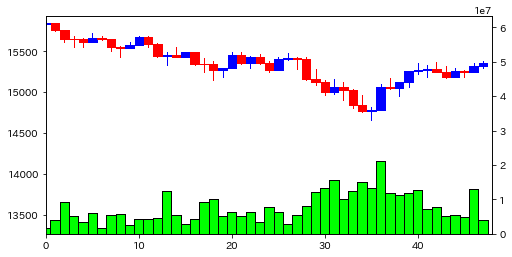

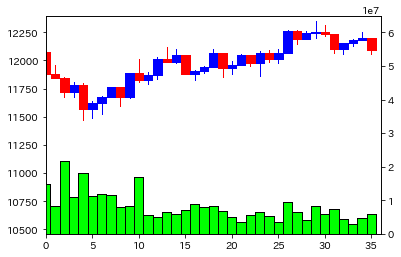

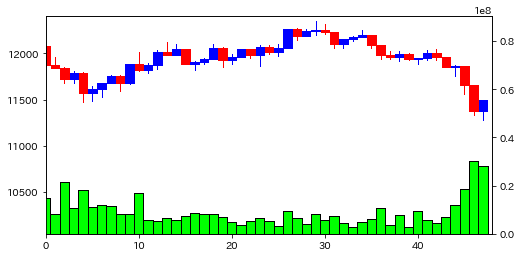

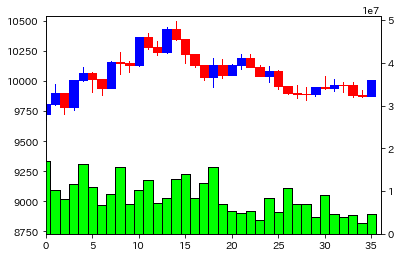

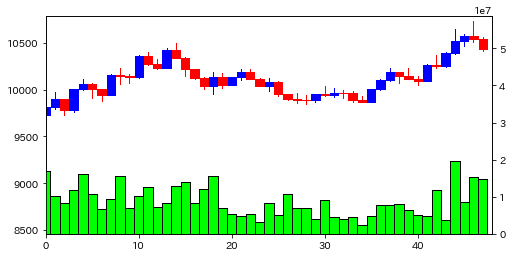

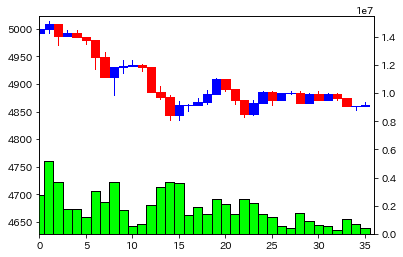

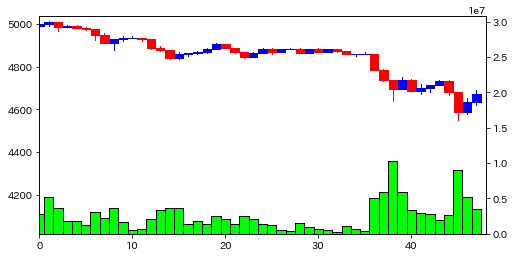

In [54]:
for i in range(1,len(alpha2)):
    plot_comp(alpha2[i-1:i])

In [55]:
alpha2[0:1]

,Dev,DevA,Diff,RRR,Base,Future,idx,idx2,idx3
164,-4.99268,4.99268,-324.0,6.545455,6489.5,6165.5,186592,186628,186640


In [56]:
alpha2[0:1]['idx'].values[0]

186592